In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import curve_fit
import datetime

$$H_R = \frac{i\eta\Omega}{2}\left(\sigma_+a+\sigma_-a^\dagger\right)$$
$$H_B = \frac{i\eta\Omega}{2}\left(\sigma_-a+\sigma_+a^\dagger\right)$$

$$\left|0\right>\otimes\left|\overline{n}\right>$$

$$\frac{P_{R, e}(t)}{P_{B, e}(t)-P_{R, e}(t)}$$

$$\overline{n}\approx 5$$

## Read the file

In [2]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, PMT1, PMT1_raw, PMT1_bottom, PMT1_top, PMT2, PMT2_raw, PMT2_bottom, PMT2_top \
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None, skiprows=0,unpack=True)
    return x, PMT1

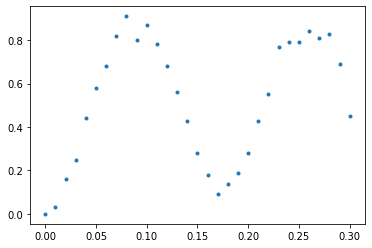

In [3]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_021')
plt.plot(xb, BSB, '.')

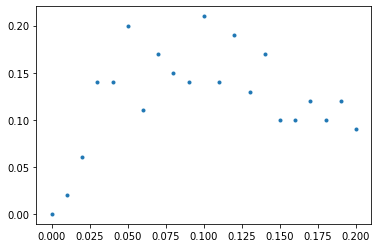

In [4]:
xr, RSB = readFile('RamanTimeScan_CounterProp_RSB_Tilt_021')
plt.plot(xr, RSB, '.')

## Define Hamiltonian

In [5]:
times = xb
nMax = 20

In [6]:
def H(n, isRed = True, Gamma = 0, etaOmega = 5*2*np.pi, times = times):
    H_R = etaOmega/2*(qt.tensor(qt.sigmap(), qt.destroy(nMax))+qt.tensor(qt.sigmam(), qt.create(nMax)))
    H_B = etaOmega/2*(qt.tensor(qt.sigmam(), qt.destroy(nMax))+qt.tensor(qt.sigmap(), qt.create(nMax)))
    
    psi_0 = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.thermal_dm(nMax, n))
    psi_1 = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.thermal_dm(nMax, n))

    c_ops = [
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*(n+1))*qt.destroy(nMax)),          # Heating
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*n)*qt.create(nMax))]
    
    if isRed == True:
        result = qt.mesolve(H_R, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    else:
        result = qt.mesolve(H_B, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    
    return result.expect[0]

### Test the Hamiltonian

(0, 1)

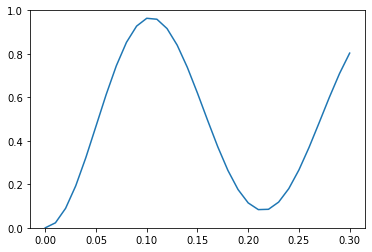

In [7]:
H0 = []
n0 = 0.1
etaOmega = 29
for t in xb:
    H0.append(H(n0, False, 0, etaOmega, [0,t])[-1]) # Test Blue sideband
plt.plot(xb,H0)
plt.ylim([0,1])

## Define heating rate fit

In [41]:
def Heating(x, a):
    return a * x
def heatingFit(xdata, ydata):
    popt, pcov = curve_fit(Heating, xdata, ydata)
    plt.plot(xdata, Heating(xdata, popt), 'b-',
         label='fit: Heating rate=%5.3f quantas/s' % tuple(popt))
    plt.plot(xdata, ydata, 'r.', label='data')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Motional quanta')
    plt.show()
    print(popt)

## Method 1: Curve fit

In [9]:
def Red(x, n0, etaOmega):
    return H(n0, True, 0, etaOmega, x)
def Blue(x, n0, etaOmega):
    return H(n0, False, 0, etaOmega, x)

In [10]:
def FitRed(xdata, ydata, guess):
    popt, pcov = curve_fit(Red, xdata, ydata, guess)
    plt.plot(xdata, Red(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.plot(xdata, ydata, 'b.', label='data')
    plt.legend()
    print(popt)
    return Red(xdata, *popt)
    
def FitBlue(xdata, ydata, guess):
    popt, pcov = curve_fit(Blue, xdata, ydata, guess)
    plt.plot(xdata, Blue(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.plot(xdata, ydata, 'b.', label='data')
    plt.legend()
    plt.show()
    print(popt)
    return popt

[ 0.28139858 28.24108109]


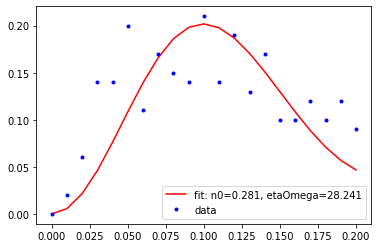

In [11]:
### RSB
xdata = xr
ydata = RSB
guess = np.array([0.1, 30])
RSB_fit = FitRed(xdata, ydata, guess)

In [12]:
### BSB
xdata = xb
ydata = BSB
guess = np.array([0.4, 29])
BSB_fit = FitBlue(xdata, ydata, guess)

[ 0.14860176 36.35968305]


#### Fit with curve_fit

The loop fitting doesn't work well because it's highly sensitive to the initial guess. We need to change it mannually

## RF = 400

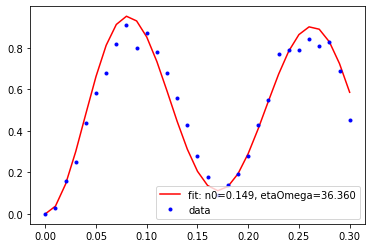

[ 0.14859834 36.35969158]


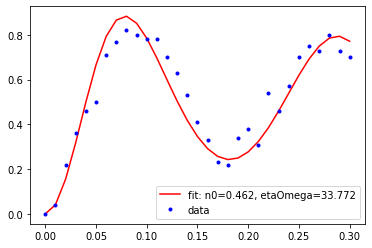

[ 0.46170806 33.77240369]


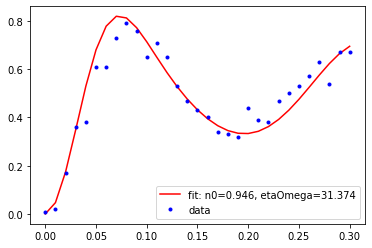

[ 0.94555846 31.37402445]


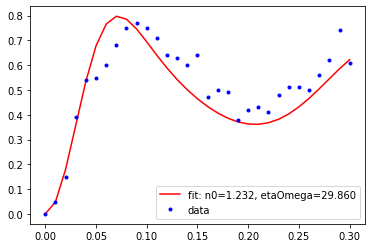

[ 1.23182801 29.86011169]


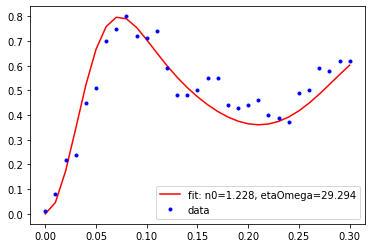

[ 1.2280477  29.29438924]


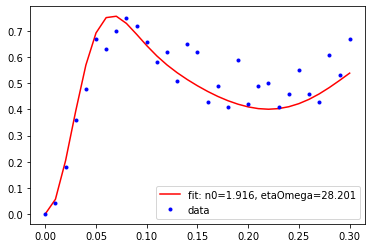

[ 1.91609696 28.20056358]


[ 5.11231807 19.3826769 ]


In [31]:
n400 = []
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_021')
guess = np.array([0.1, 29])
BSB_fit = FitBlue(xb, BSB, guess)
n400.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_022')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n400.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_023')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n400.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_024')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n400.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_025')
guess = np.array([1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n400.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_026')
guess = np.array([1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n400.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_027')
guess = np.array([1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n400.append(BSB_fit[0])

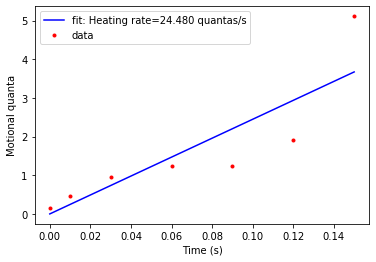

[24.47978134]


In [32]:
T = [0, 0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
heatingFit(T, n400)

## RF = 450

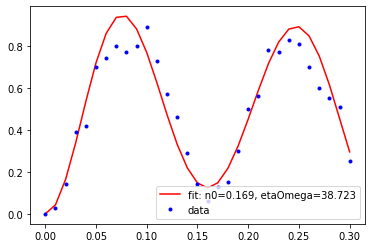

[ 0.16850394 38.72265377]


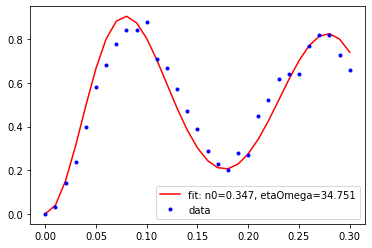

[ 0.34650456 34.75057299]


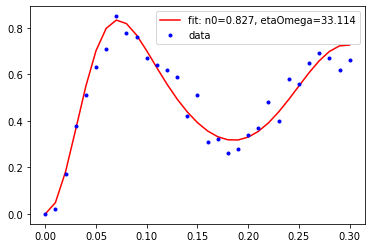

[ 0.82666379 33.11388809]


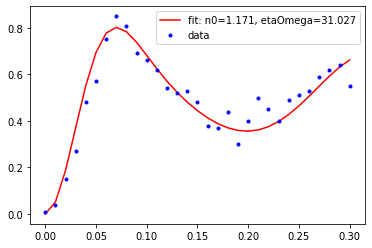

[ 1.17119394 31.02678834]


[ 1.63618799 30.78133669]


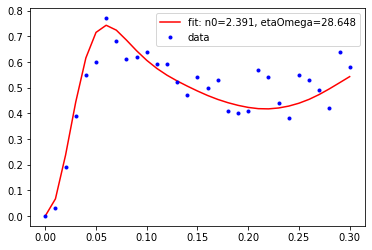

[ 2.3911404  28.64826746]


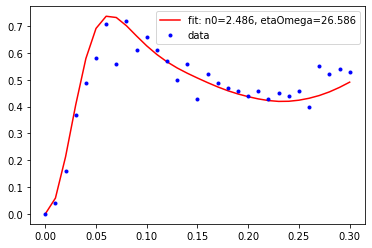

[ 2.48593209 26.58630218]


In [21]:
n450 = []
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_012')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n450.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_013')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n450.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_014')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n450.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_015')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n450.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_016')
guess = np.array([1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n450.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_017')
guess = np.array([1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n450.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_018')
guess = np.array([1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n450.append(BSB_fit[0])

In [22]:
T = [0, 0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
heatingFit(T, n450)

[18.25847129]


## RF = 500

[ 0.13066292 39.27871805]


[ 0.33174872 37.58414394]


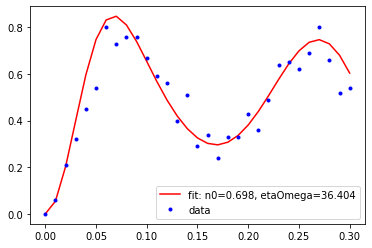

[ 0.69750357 36.40430077]


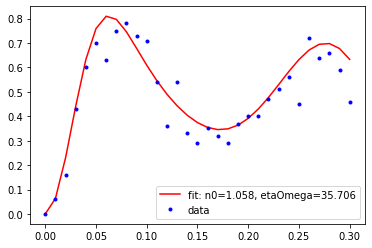

[ 1.05819289 35.70560964]


[ 1.87009197 31.61017661]


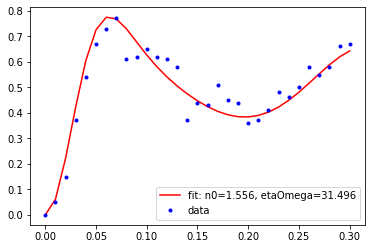

[ 1.55570055 31.49644868]


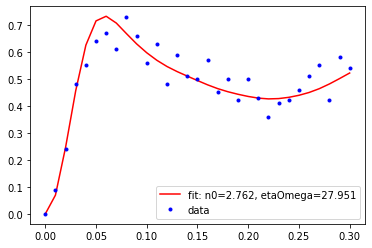

[ 2.76223522 27.9508427 ]


In [26]:
n500 = []
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_002')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n500.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_003')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n500.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_004')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n500.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_005')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n500.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_006')
guess = np.array([1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n500.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_007')
guess = np.array([1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n500.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_008')
guess = np.array([1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n500.append(BSB_fit[0])

In [27]:
T = [0, 0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
heatingFit(T, n500)

[17.27947166]


(0, 110)

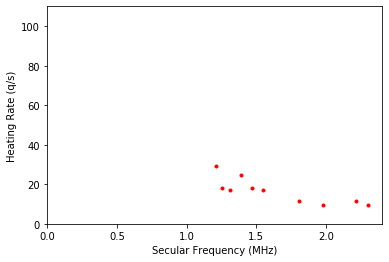

In [70]:
RF = [265, 300, 325, 350, 400, 450, 500, 650, 750, 850, 910]
'''freqs = [223.8058, 223.7878, 223.7438, 223.6863, 223.61195, 223.5292, 223.4497,223.1914,223.0193, \
        222.7845, 222.7008]
HeatingRates = [99.0843523, 29.139752,18.12975992,17.25775145,24.47978134,18.25847129,17.27947166,11.7490, \
                9.5663,11.716, 9.7402]'''
freqs = [223.7878, 223.7438, 223.6863, 223.61195, 223.5292, 223.4497,223.1914,223.0193, \
        222.7845, 222.7008]
HeatingRates = [29.139752,18.12975992,17.25775145,24.47978134,18.25847129,17.27947166,11.7490, \
                9.5663,11.716, 9.7402]
secularF = []
for f in freqs:
    secularF.append(225-f)
plt.plot(secularF, HeatingRates, 'r.')
plt.xlabel('Secular Frequency (MHz)')
plt.ylabel('Heating Rate (q/s)')
plt.xlim([0,2.4])
plt.ylim([0,110])

In [81]:
def HeatingVsFreq(x, a):
    return a/x
def HeatingVsFreqFit(xdata, ydata):
    popt, pcov = curve_fit(HeatingVsFreq, xdata, ydata)
    plt.plot(xdata, HeatingVsFreq(xdata, popt), 'b-',
         label='fit: %5.3f /f' % tuple(popt))
    plt.plot(xdata, ydata, 'r.', label='data')
    plt.legend()
    plt.xlabel('Secular Frequency (MHz)')
    plt.ylabel('Heating Rate (q/s)')
    plt.xlim([0,2.5])
    plt.show()
    print(popt)

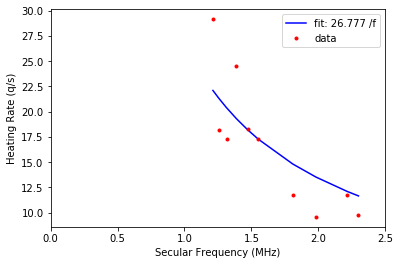

[26.77650929]


In [82]:
HeatingVsFreqFit(secularF, HeatingRates)

Text(0, 0.5, 'Heating Rate (q/s)')

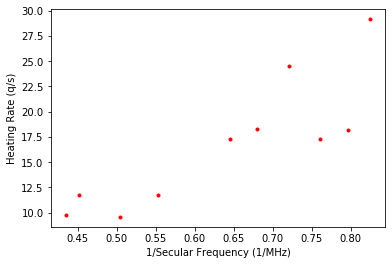

In [71]:
invF = []
for f in freqs:
    invF.append(1/(225-f))
plt.plot(invF, HeatingRates, 'r.')
plt.xlabel('1/Secular Frequency (1/MHz)')
plt.ylabel('Heating Rate (q/s)')

In [73]:
def HeatingVsInvFreq(x, a):
    return a*x
def HeatingVsFreqFit(xdata, ydata):
    popt, pcov = curve_fit(HeatingVsInvFreq, xdata, ydata)
    plt.plot(xdata, HeatingVsFreq(xdata, popt), 'b-',
         label='fit: %5.3f /f' % tuple(popt))
    plt.plot(xdata, ydata, 'r.', label='data')
    plt.legend()
    plt.xlabel('1/Secular Frequency (1/MHz)')
    plt.ylabel('Heating Rate (q/s)')
    plt.show()
    print(popt)

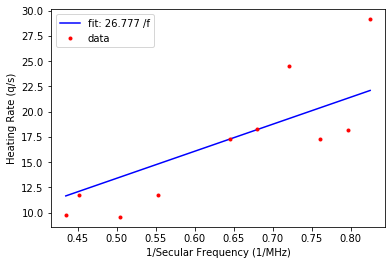

[26.7765093]


In [74]:
HeatingVsFreqFit(invF, HeatingRates)

## Method 2: Least square fitting (Not used here)

In [34]:
def LeastSquareFitting(x, ydata, fitdata):
    R = 0
    for i in range(len(x)):
        R += (ydata[i]-fitdata[i])**2
    return R

Test it

In [35]:
n0 = 5
Gamma = 0.1
etaOmega = etaOmega = 5*2*np.pi
H_red = H(n0, True, Gamma, etaOmega)
LeastSquareFitting(x, RSB, H_red)

3.3433825459824194

In [44]:
def ScanParameters(n0s, etaOmegas, xb, BSB):
    R_red = np.zeros((len(n0s), len(etaOmegas))) 
    R_blue = np.zeros((len(n0s), len(etaOmegas)))  
    Gamma = 0
    for i in range(len(n0s)):
        for j in range(len(etaOmegas)):
            #H_red = H(n0s[i], True, Gamma, etaOmegas[j])
            H_blue = H(n0s[i], False, Gamma, etaOmegas[j], times = xb)
            #R_red[i][j] = LeastSquareFitting(x, RSB, H_red)
            R_blue[i][j] = LeastSquareFitting(xb, BSB, H_blue)
    #return R_red, R_blue
    return R_blue

## Write the cell above as a function

In [115]:
# Caution: The time cost will be long if the range of scanning is too large

def lSFit(filenames, n0s, etaOmegas, waitTime):
    # filenames contains the files with different waiting time for one RF setting
    # n0s is the scanning range for motional quanta
    # etaOmegas is the scanning range for eta*Omega
    # waitTime is an array contains corresponding waitTime
    
    
    
    now1 = datetime.datetime.now()

    n = []
    for i in range(len(filenames)):
        xb, BSB = readFile(filenames[i])
        R_blue = ScanParameters(n0s, etaOmegas, xb, BSB)
        plt.imshow(R_blue)
        plt.show()

        row, col = np.where(R_blue == R_blue.min())
        n0 = n0s[row][0]
        etaOmega = etaOmegas[col][0]
        print(n0)
        print(etaOmega)

        ax2 = plt.subplot(111)
        ax2.plot(xb, H(n0, False, 0, etaOmega, xb), label = "BSB Rabi Oscillation")
        ax2.plot(xb, BSB, 'b.')
        ax2.set_xlabel("Time")
        ax2.set_ylabel("$P_e$")
        ax2.legend(loc = "upper right")
        plt.show()


        n.append(n0)
    
    heatingFit(T, n)
    now2 = datetime.datetime.now()
    print(now2-now1)

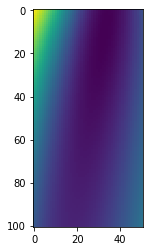

0.09909999999999998
18.6


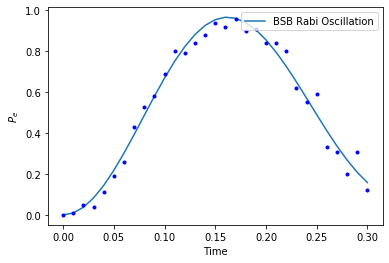

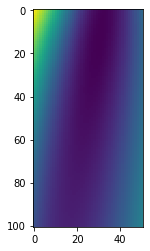

0.11889999999999999
18.2


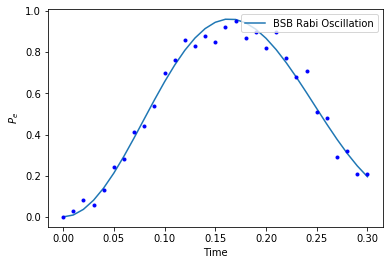

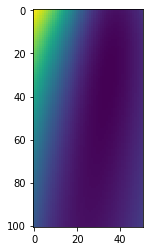

0.3367
18.8


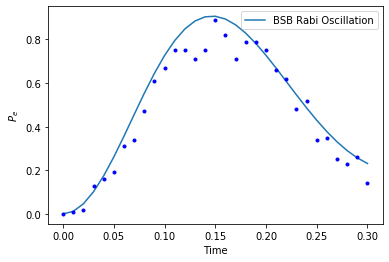

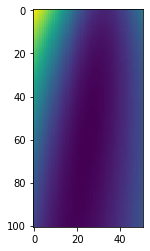

0.604
17.0


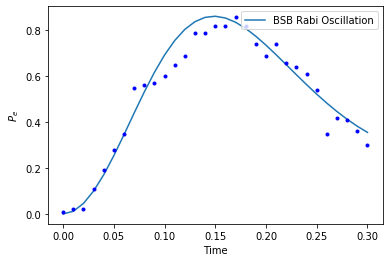

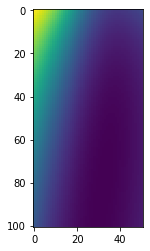

0.8218
18.4


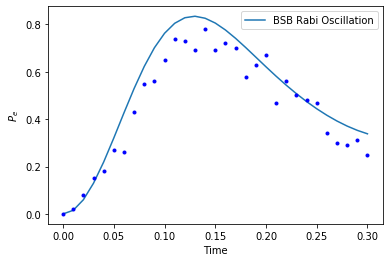

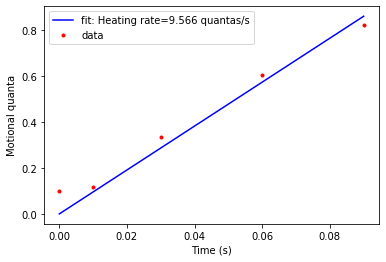

[9.56629921]
0:06:45.877652


In [58]:
n0s = np.linspace(0.01, 1, 101)
etaOmegas = np.linspace(12, 22, 51)
waitTime = [0.0, 0.01, 0.03, 0.06, 0.09]

lSFit(BSB750, n0s, etaOmegas, waitTime)